# Cleaning Up the Annotated RNA-seq data

Tong Shu Li

In this notebook, we clean up the raw annotated RNA-seq data file `(Q1_Sunitha_RNAseq_36samples_annotated.raw)` and prepare it for subsequent use.

To begin, run `dos2unix` on the file to remove carriage returns (`\r`).

In [1]:
import operator
import pandas as pd
import seaborn as sns

from functools import reduce

In [2]:
%matplotlib inline

---

## Read the raw data

In [3]:
data = pd.read_csv("Q1_Sunitha_RNAseq_36samples_annotated.raw", sep = '\t')

In [4]:
data.head()

,seqname,samples,value,cohort,replicate,age,drug,conc,add,youngref,td,wormbaseid,symbol,v1
0,2L52.1,11,3.486620,1,1,1,h2o,0,1,1.779111,0.672818,WBGene00007063,2L52.1,2L52.1
1,2L52.1,12,0.963996,1,2,1,h2o,0,1,1.779111,-0.612782,WBGene00007063,2L52.1,2L52.1
2,2L52.1,13,0.886719,1,3,1,h2o,0,1,1.779111,-0.696341,WBGene00007063,2L52.1,2L52.1
3,2L52.1,21,3.529880,2,1,3,h2o,0,1,1.779111,0.685150,WBGene00007063,2L52.1,2L52.1
4,2L52.1,22,3.392530,2,2,3,h2o,0,1,1.779111,0.645462,WBGene00007063,2L52.1,2L52.1


In [5]:
data.shape

(690084, 14)

## Delete the redundant v1 column

The `v1` column is redundant because it is equal to the `symbol` column for all rows:

In [6]:
all(data["v1"] == data["symbol"])

True

In [7]:
data = data.drop("v1", axis = 1)

## Rename the values in the `drug` column

We will rename `h2o` and `mia` to the more informative `water` and `mianserin` in the `drug` column.

In [8]:
data = data.replace({"drug": {"h2o": "water", "mia": "mianserin"}})

In [9]:
data["drug"].value_counts()

mianserin    460056
water        230028
Name: drug, dtype: int64

## Rename the columns to be more descriptive

In [10]:
data = data.rename(
    columns = {
        "age": "day_harvested",
        "conc": "drug_conc_uM",
        "add": "day_drug_added",
        "td": "RLFEC", # relative log fold expression change
        "symbol": "gene_symbol",
        "value": "cpm_value",
        "youngref": "youngref_cpm"
    }
)

In [11]:
data.head()

,seqname,samples,cpm_value,cohort,replicate,day_harvested,drug,drug_conc_uM,day_drug_added,youngref_cpm,RLFEC,wormbaseid,gene_symbol
0,2L52.1,11,3.486620,1,1,1,water,0,1,1.779111,0.672818,WBGene00007063,2L52.1
1,2L52.1,12,0.963996,1,2,1,water,0,1,1.779111,-0.612782,WBGene00007063,2L52.1
2,2L52.1,13,0.886719,1,3,1,water,0,1,1.779111,-0.696341,WBGene00007063,2L52.1
3,2L52.1,21,3.529880,2,1,3,water,0,1,1.779111,0.685150,WBGene00007063,2L52.1
4,2L52.1,22,3.392530,2,2,3,water,0,1,1.779111,0.645462,WBGene00007063,2L52.1


The young reference cpm column is calculated by taking the mean cpm value for all three young reference samples (cohort = 1) within each gene. The `RLFEC` column is calculated as the natural log of the `cpm_value` column divided by the `youngref_cpm column`.

---

## Explore the data

In [12]:
# number of unique genes
data["seqname"].nunique()

19169

In [13]:
# check that the full transcriptome was measured for each replicate of each sample
data.groupby(["cohort", "replicate"])["seqname"].nunique().value_counts()

19169    36
Name: seqname, dtype: int64

All 36 individual samples were sequenced for the full 19169 genes.

### Distribution of the number of genes missing in each sample

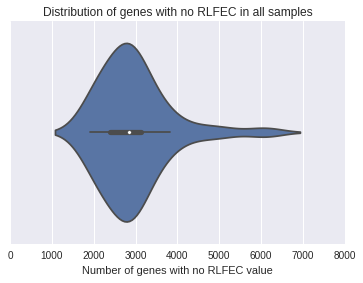

In [14]:
ax = (data
    .groupby(["cohort", "replicate"])
    .apply(lambda f: f["RLFEC"].isnull().sum())
    .pipe(sns.violinplot)
)

ax.set_title("Distribution of genes with no RLFEC in all samples")
ax.set_xlabel("Number of genes with no RLFEC value");

On average, each of the 36 samples is missing RLFEC values for approximately 3000 genes.

### Number of samples missing the RLFEC value for each gene

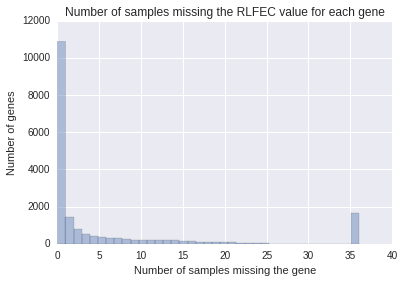

In [15]:
ax = (data
    .groupby("seqname")
    .apply(lambda df: df["RLFEC"].isnull().sum())
    .pipe(sns.distplot, kde = False, bins = 37)
)

ax.set_title("Number of samples missing the RLFEC value for each gene")
ax.set_xlabel("Number of samples missing the gene")
ax.set_ylabel("Number of genes");

In [16]:
missing_genes = {
    info: set(df[df["RLFEC"].isnull()]["seqname"])
    for info, df in data.groupby(["cohort", "replicate"])
}

print("# unique genes with no drift value in all samples:",
    len(reduce(operator.and_, missing_genes.values()))
)

print("# unique genes with no drift value in any sample:",
    len(reduce(operator.or_, missing_genes.values()))
)

# unique genes with no drift value in all samples: 1653
# unique genes with no drift value in any sample: 8290


Although we measured the expression values for all 19169 genes, we do not have the drift values for 1653 genes in all 36 samples. This means that either the value of expression or the young reference for that gene was 0.

We will need to exclude these genes from our analysis, since they provide us with no information.

---

## Discard any genes which have no RLFEC value in any sample

Since we want to be consistent, with three replicates for each measurement, we will discard any genes which are missing in **any** sample.

In [17]:
good = data.groupby("wormbaseid").filter(lambda df: all(df["RLFEC"].notnull()))

In [18]:
good.shape

(391644, 13)

In [19]:
good.head()

,seqname,samples,cpm_value,cohort,replicate,day_harvested,drug,drug_conc_uM,day_drug_added,youngref_cpm,RLFEC,wormbaseid,gene_symbol
36,2RSSE.1,11,4.55942,1,1,1,water,0,1,4.105726,0.104814,WBGene00007064,2RSSE.1
37,2RSSE.1,12,3.21332,1,2,1,water,0,1,4.105726,-0.245078,WBGene00007064,2RSSE.1
38,2RSSE.1,13,4.54444,1,3,1,water,0,1,4.105726,0.101521,WBGene00007064,2RSSE.1
39,2RSSE.1,21,11.43680,2,1,3,water,0,1,4.105726,1.024454,WBGene00007064,2RSSE.1
40,2RSSE.1,22,4.77467,2,2,3,water,0,1,4.105726,0.150942,WBGene00007064,2RSSE.1


In [20]:
good["seqname"].nunique()

10879

We have effectively reduced the number of genes we are measuring from 19169 to 10879, which is around half the size.

## Write filtered genes to file

In [21]:
good.to_csv("clean_annotated_cpm_values.tsv", sep = '\t', index = False)

## Average drift values across replicates

We produce one version of the data where expression values are averaged across replicates, and one where they are not.

In [22]:
avg = (good
    .groupby(["seqname", "cohort"], as_index = False)
    .mean()
    .drop(["samples", "replicate"], axis = 1)
    .merge(
        good[["seqname", "cohort", "drug", "wormbaseid", "gene_symbol"]].drop_duplicates(),
        how = "inner", on = ["seqname", "cohort"])
    .rename(columns = {"cohort": "sample"})
)

In [23]:
avg.shape

(130548, 11)

In [24]:
avg.head()

,seqname,sample,cpm_value,day_harvested,drug_conc_uM,day_drug_added,youngref_cpm,RLFEC,drug,wormbaseid,gene_symbol
0,2RSSE.1,1,4.105727,1,0,1,4.105726,-0.012915,water,WBGene00007064,2RSSE.1
1,2RSSE.1,2,7.687213,3,0,1,4.105726,0.562429,water,WBGene00007064,2RSSE.1
2,2RSSE.1,3,7.220500,5,0,1,4.105726,0.562490,water,WBGene00007064,2RSSE.1
3,2RSSE.1,4,3.923197,10,0,1,4.105726,-0.049039,water,WBGene00007064,2RSSE.1
4,2RSSE.1,5,4.042023,3,50,1,4.105726,-0.030335,mianserin,WBGene00007064,2RSSE.1


## Save to file

In [25]:
avg.to_csv("avg_annotated_cpm_values.tsv", sep = '\t', index = False)